# Understanding sklearn GPR error interpretation

In [164]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close();
plt.rcParams.update({'font.size':16})

import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
from sklearn.model_selection import GridSearchCV, ParameterGrid

<Figure size 432x288 with 0 Axes>

In [165]:
def get_data(N, noise_sd=0.005):
    x = np.random.normal(0, 0.1, N)
    
    y_true_f = lambda x: x**2 * np.sin(4*x)
    
    y = y_true_f(x)
    
    y_noise = np.random.normal(0, noise_sd, N)
    
    y+=y_noise
    
    x_fine = np.linspace(np.min(x), np.max(x), 1000)
    y_fine = y_true_f(x_fine)
    
    return x[:,np.newaxis], y, x_fine[:,np.newaxis], y_fine

In [166]:
X, y, X_fine, y_fine = get_data(1000)

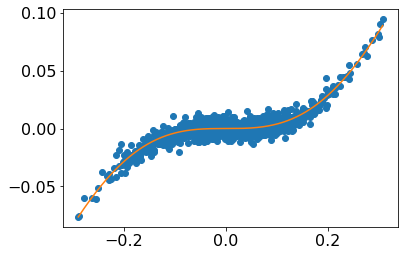

In [167]:
plt.figure()
plt.plot(X, y, 'o')
plt.plot(X_fine, y_fine)

In [168]:
# kernel = kernels.RBF() * kernels.ConstantKernel() #+ kernels.WhiteKernel()
# alpha=1e-3
# alpha=1e-10
# alpha=1e-5

# gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=0, n_restarts_optimizer=10).fit(X, y)

In [169]:
param_grid = [{
    'alpha':np.logspace(-10,-1,10)
}]
pg = ParameterGrid(param_grid)

In [170]:
# param_grid = [{
#     'alpha':[y.std()**2]
# }]
# pg = ParameterGrid(param_grid)

In [171]:
%%time
gps = []
scores = []
ps = []
for p in pg:
    ps.append(p)
for p in ps:
    kernel = kernels.RBF() * kernels.ConstantKernel() +  kernels.ConstantKernel()*kernels.WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel, **p)
    gp.fit(X, y)
    gps.append(gp)
    scores.append(gp.log_marginal_likelihood_value_)
scores = np.array(scores)

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better valu

CPU times: user 1min 14s, sys: 28.2 s, total: 1min 42s
Wall time: 20.6 s


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better valu

In [172]:
scores

array([3867.90560457, 3867.90560486, 3867.90560486, 3867.90560485,
       3867.90560485, 3867.90560485, 3543.166889  , 2487.61093172,
       1375.0964614 ,  231.32607776])

In [173]:
np.argmax(scores)

2

In [174]:
ps[np.argmax(scores)]

{'alpha': 1e-08}

In [175]:
gpr = gps[np.argmax(scores)]
# gpr = gps[6]

In [176]:
gpr.log_marginal_likelihood_value_

3867.90560485605

In [177]:
X.shape

(1000, 1)

In [178]:
gpr

GaussianProcessRegressor(alpha=1e-08,
                         kernel=RBF(length_scale=1) * 1**2 + 1**2 * WhiteKernel(noise_level=1))

In [179]:
gpr.kernel_

RBF(length_scale=0.341) * 0.192**2 + 0.0703**2 * WhiteKernel(noise_level=0.00494)

In [180]:
gpr.score(X, y)

0.8763920176712003

In [181]:
yhat_samples = gpr.sample_y(X_fine, n_samples=100)
yhat_samples = yhat_samples.T

In [182]:
yhat_mean, yhat_cov = gpr.predict(X_fine, return_cov=True)

In [183]:
%%timeit
yhat_mean, yhat_cov = gpr.predict(X_fine, return_cov=True)

39.2 ms ± 4.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [184]:
yhat_mean.shape

(1000,)

In [185]:
yhat_cov.shape

(1000, 1000)

In [186]:
yhat_std = np.sqrt(np.diagonal(yhat_cov))

In [187]:
yhat_std.shape

(1000,)

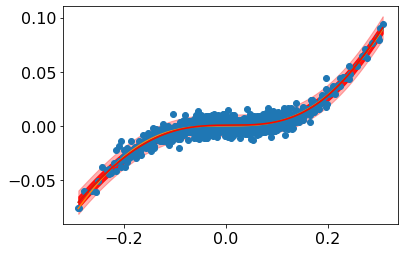

In [188]:
plt.figure()
plt.plot(X, y, 'o')
plt.plot(X_fine, y_fine)
plt.plot(X_fine, yhat_mean, '-')
# for yhat_sample in yhat_samples[:10]:
#     plt.plot(X_fine, yhat_sample,'k', alpha=0.4)
    
plt.plot(X_fine, yhat_mean, color='r')
plt.fill_between(X_fine[:,0], y1=yhat_mean-yhat_std, y2=yhat_mean+yhat_std, color='r', alpha=0.9)
plt.fill_between(X_fine[:,0], y1=yhat_mean-2*yhat_std, y2=yhat_mean+2*yhat_std, color='r', alpha=0.3)

In [189]:
y.std()**2

0.00019667019750843682

In [190]:
gpr.kernel_.k2.get_params()['k2__noise_level']

0.004943323163806033

In [191]:
yhat_mean = gpr.predict(X_fine, return_cov=False, return_std=False)

In [192]:
yhat_mean.shape

(1000,)

In [193]:
sds = np.random.normal(0, gpr.kernel_.k2.get_params()['k2__noise_level'], size=(100,1))

In [194]:
yhat_samples_new = yhat_mean + sds

In [195]:
yhat_samples_new.shape

(100, 1000)

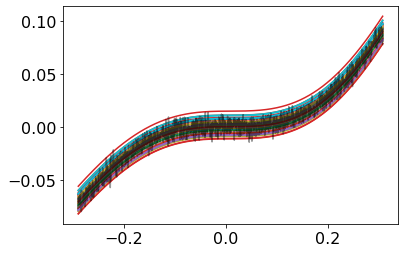

In [196]:
for yy in yhat_samples_new:
    plt.plot(X_fine, yy)
for yhat_sample in yhat_samples[:2]:
    plt.plot(X_fine, yhat_sample,'k', alpha=0.4)

In [197]:
X_fine.shape

(1000, 1)

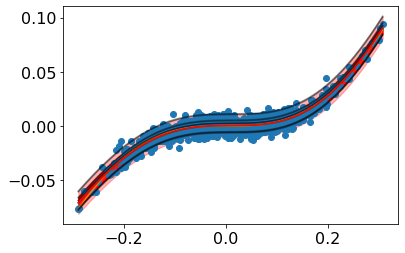

In [198]:
plt.figure()
plt.plot(X, y, 'o')
plt.plot(X_fine, y_fine)
plt.plot(X_fine, yhat_mean, '-')
for yhat_sample in yhat_samples_new[:10]:
    plt.plot(X_fine, yhat_sample,'k', alpha=0.4)
    
plt.plot(X_fine, yhat_mean, color='r')
plt.fill_between(X_fine[:,0], y1=yhat_mean-yhat_samples_new.std(0), y2=yhat_mean+yhat_samples_new.std(0), color='r', alpha=0.9)
plt.fill_between(X_fine[:,0], y1=yhat_mean-2*yhat_samples_new.std(0), y2=yhat_mean+2*yhat_samples_new.std(0), color='r', alpha=0.3)

In [250]:
%%timeit
gpr_samples_sklearn = gpr.sample_y(X_fine, 1000)

939 ms ± 61.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [254]:
gpr_samples_sklearn = gpr.sample_y(X_fine, 1000).T

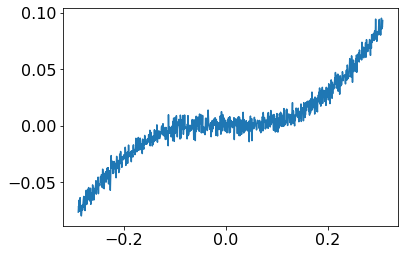

In [255]:
plt.plot(X_fine, gpr_samples_sklearn[0])

# summary

 - using alpha=y.std()**2 doesn't result in the best (visually) model
 - using a WhiteKernel to estimate the noise level (independently of alpha) and then extracting this value and using it to set the scale for a normal distribution and adding in a constant offset seems to work well though

# tinygp 

In [199]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp

import tinygp
import tinygp.kernels

In [200]:
# class SpectralMixture(tinygp.kernels.Kernel):
#     def __init__(self, weight, scale, freq):
#         self.weight = jnp.atleast_1d(weight)
#         self.scale = jnp.atleast_1d(scale)
#         self.freq = jnp.atleast_1d(freq)

#     def evaluate(self, X1, X2):
#         tau = jnp.atleast_1d(jnp.abs(X1 - X2))[..., None]
#         return jnp.sum(
#             self.weight
#             * jnp.prod(
#                 jnp.exp(-2 * jnp.pi**2 * tau**2 / self.scale**2)
#                 * jnp.cos(2 * jnp.pi * self.freq * tau),
#                 axis=-1,
#             )
#         )

In [201]:
# spm = SpectralMixture(1,1,1)

In [202]:
# spm(X)

In [203]:
# # class WhiteNoise(tinygp.kernels.Kernel):
# #     def __init__(self, scale):
# #         self.scale = jnp.atleast_1d(scale)

# #     def evaluate(self, X1, X2=None):
# #         if X2 is None:
# #             delta = jnp.eye(len(X1), len(X1))
# #             return self.scale * delta
# #         else:
# #             return jnp.zeros((len(X1), len(X2)))

# class WhiteNoise(tinygp.kernels.Kernel):
#     def __init__(self, scale):
#         self.scale = jnp.atleast_1d(scale)

#     def evaluate(self, X1, X2):
#         if X1==X2:
#             return self.scale[0]
#         else:
#             return 0

In [204]:
# wn=WhiteNoise(1)

In [205]:
# wn(X,X)

In [206]:
# exps = tinygp.kernels.ExpSquared(1e-3)

In [207]:
# plt.matshow( exps(X,X))

In [208]:
# exps.evaluate_diag(X)

In [224]:



def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amps = jnp.exp(theta["log_amps"])
    scales = jnp.exp(theta["log_scales"])

    # Construct the kernel by multiplying and adding `Kernel` objects
    k1 = amps[0] * tinygp.kernels.ExpSquared(scales[0])
    # k2 = amps[1] * WhiteNoise(scales[1])
    kernel = k1 #+ k2

    return tinygp.GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]), #mean=theta["mean"]
    )


def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "mean": np.float64(340.0),
    # "log_diag": np.log(0.19),
    # "log_diag": np.log(y.std()**2),
    "log_diag": np.log(0.1),
    # "log_amps": np.log([66.0, 2]),
    # "log_scales": np.log([67.0, 2]),
    "log_amps": np.log([66.0]),
    "log_scales": np.log([67.0]),
}

# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, X, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, X, y)[1]}"
)

Initial negative log likelihood: -224.57079455778788
Gradient of the negative log likelihood, wrt the parameters:
{'log_amps': Array([0.65449785], dtype=float64), 'log_diag': Array(498.71275458, dtype=float64), 'log_scales': Array([-0.30899869], dtype=float64)}


In [225]:
import jaxopt

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=X, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: -3867.905604854979


In [226]:
np.log(0.19)

-1.6607312068216509

In [227]:
np.exp(soln.params['log_diag'])

2.4446453184304237e-05

In [228]:
soln.params

{'log_amps': Array([-3.2984884], dtype=float64),
 'log_diag': Array(-10.61902542, dtype=float64),
 'log_scales': Array([-1.0761601], dtype=float64)}

In [266]:
gp = build_gp(soln.params, X)
cond_gp = gp.condition(y, X_fine, diag=np.exp(soln.params['log_diag'])).gp
mu, var = cond_gp.loc, cond_gp.variance
std = np.sqrt(var)

In [230]:
%%timeit
gp.condition(y, X_fine, diag=np.exp(soln.params['log_diag'])).gp

62.4 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [231]:
mu.shape

(1000,)

In [232]:
var.shape

(1000,)

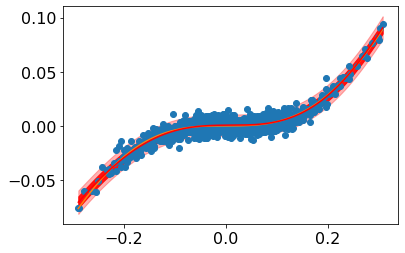

In [233]:
plt.figure()
plt.plot(X, y, 'o')
plt.plot(X_fine, y_fine)
# for yhat_sample in yhat_samples[:10]:
#     plt.plot(X_fine, yhat_sample,'k', alpha=0.4)
    
plt.plot(X_fine, mu, color='r')
plt.fill_between(X_fine[:,0], y1=mu-std, y2=mu+std, color='r', alpha=0.9)
plt.fill_between(X_fine[:,0], y1=mu-2*std, y2=mu+2*std, color='r', alpha=0.3)

# sampling from conditioned GP

- If we include `diag` in `gp.condition` then the samples we get will be i.i.d with that noise
- If we instead want to assume a constant noise offset then we have to not pass in a `diag` to `gp.condition` but use the learned `diag` and add noise from a gaussian

## using `diag`

In [269]:
cond_gp = gp.condition(y, X_fine, diag=np.exp(soln.params['log_diag'])).gp

In [273]:
gp_samples = cond_gp.sample(jax.random.PRNGKey(4), shape=(500,))

In [274]:
gp_samples.shape

(500, 1000)

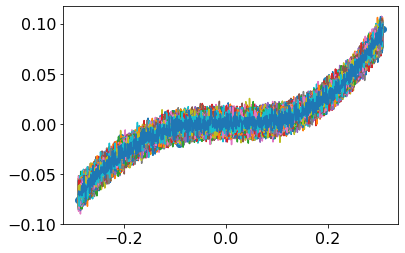

In [310]:
plt.figure()
plt.plot(X, y, 'o')
for s in gp_samples:
    plt.plot(X_fine, s)

## not using `diag`

In [276]:
cond_gp_2 = gp.condition(y, X_fine).gp

In [277]:
gp_samples_2 = cond_gp_2.sample(jax.random.PRNGKey(4), shape=(500,))

In [278]:
gp_samples_2.shape

(500, 1000)

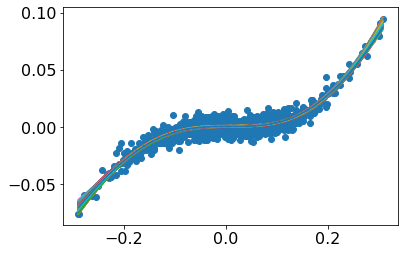

In [312]:
# this plot shows that the variation is much lower than we expected
plt.figure()
plt.plot(X, y, 'o')
for s in gp_samples_2:
    plt.plot(X_fine, s)

In [292]:
noise = np.random.normal(0, np.sqrt(np.exp(soln.params['log_diag'])), size=(500,1))

In [293]:
gp_samples_2_w_noise = gp_samples_2 + noise

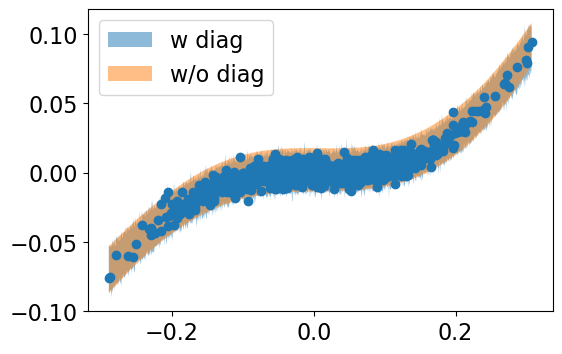

In [314]:
# this plot shows that we can get smooth individual samples w/o diag and adding N(0, sqrt(diag)) noise after
plt.figure(dpi=100)
plt.plot(X, y, 'o')
plt.fill_between(X_fine[:,0], y1=gp_samples.min(0), y2=gp_samples.max(0), alpha=0.5, label='w diag')
plt.fill_between(X_fine[:,0], y1=gp_samples_2_w_noise.min(0), y2=gp_samples_2_w_noise.max(0), alpha=0.5, label='w/o diag')
plt.legend()